<img src="http://imgur.com/1ZcRyrc.png" style="float: centre; margin: 20px; height: 55px">

# Project 3: Web API & NLP Part 2: EDA , Modelling & Conclusion

### Lo Kok Fu DSIF 2

## Contents:

### Part 1:
- Import Library
- Data Collection: Web Scrapping using API


### Part 2:
- Import Library and Datasets
- Data Cleaning
- Preprocessing
- EDA
- Modelling
- Evaluation
- Conclusion & Summary

## Import libraries & Datasets

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

#Sentiment analyser
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve, roc_auc_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LogisticRegression

# Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import datasets

bali_df = pd.read_csv('./datasets/bali_submission.csv')
bali_comments = pd.read_csv('./datasets/bali_comment.csv')

phuket_df = pd.read_csv('./datasets/phuket_submission.csv')
phuket_comments = pd.read_csv('./datasets/phuket_comment.csv')

## Data Cleaning

- We will concat bali and phuket submission posts to a dataset and comments to another dataset

In [3]:
# concat both island submission dataset to submission_df
submission_df = pd.concat([bali_df, phuket_df], ignore_index = True)

#concat both island comments dataset to comments_df
comments_df = pd.concat([bali_comments, phuket_comments], ignore_index = True)


In [4]:
#check
submission_df = submission_df[['subreddit', 'selftext', 'title']]
submission_df.head()

,subreddit,selftext,title
0,bali,NaN,PARASHAKTI AKASHIC READING || 22 SEPT 2021
1,bali,[removed],SBOBET PUSAT JUDI ONLINE
2,bali,[removed],North Bali beachfront resort offered for sale ...
3,bali,[removed],Coming to Bali from Australia
4,bali,[removed],Getting into bali with a business visa


In [5]:
comments_df = comments_df[['subreddit', 'body']]
comments_df.head()

,subreddit,body
0,bali,I have no idea about the official visa website...
1,bali,Your submission has been removed for suspected...
2,bali,You need a specialised Covid19 test for overse...
3,bali,Your submission has been removed for suspected...
4,bali,It's entirely possible I posted this in anothe...


In [6]:
# check any null data in submission_df
submission_df.isna().sum()

subreddit      0
selftext     617
title          0
dtype: int64

In [7]:
# fill na with ''
submission_df.fillna('', inplace = True)

# check
submission_df.isna().sum()

subreddit    0
selftext     0
title        0
dtype: int64

In [8]:
# check any null data in comments_df
comments_df.isna().sum()

subreddit    0
body         0
dtype: int64

In [9]:
# i noticed there are redundent text in 'selftext' col, '[removed]' in 151 of the selftext col. 
#it may be a video/image posted in the reddit forum and when we scrapped the forum, 
# the data does not read the media resources hence throwing the value of [removed]
submission_df[submission_df['selftext'] == '[removed]'].head()

,subreddit,selftext,title
1,bali,[removed],SBOBET PUSAT JUDI ONLINE
2,bali,[removed],North Bali beachfront resort offered for sale ...
3,bali,[removed],Coming to Bali from Australia
4,bali,[removed],Getting into bali with a business visa
5,bali,[removed],"Sorry, I'm really just not understanding re: S..."


In [10]:
submission_df[submission_df['selftext'] == '[removed]'].shape

(151, 3)

In [11]:
# replacing all strings '[removed]' in col with '' as they may affect our modelling later
submission_df['selftext'].replace('[removed]', '', inplace = True)

# check replaced
submission_df[submission_df['selftext'] == '[removed]'].shape

(0, 3)

In [12]:
# Drop duplicates in submission_df
submission_df.drop_duplicates(subset = 'title', inplace = True)

# check duplicates dropped
submission_df.shape

(1558, 3)

In [13]:
# Drop duplicates in comments_df
comments_df.drop_duplicates(subset = 'body', inplace = True)

# check duplicates dropped
comments_df.shape

(1517, 2)

In [14]:
# combine create new col'features' of selftext and title feature. Then drop existing cols of submission_df
submission_df['features'] = submission_df['selftext'] + submission_df['title']
submission_df.drop(['selftext', 'title'], axis = 1, inplace = True)

# Check
submission_df.head()

,subreddit,features
0,bali,PARASHAKTI AKASHIC READING || 22 SEPT 2021
1,bali,SBOBET PUSAT JUDI ONLINE
2,bali,North Bali beachfront resort offered for sale ...
3,bali,Coming to Bali from Australia
4,bali,Getting into bali with a business visa


In [15]:
### Rename, concat, mapping and drop unnecssary columns

In [16]:
# rename comments_df['body'] to ['features'] in prep for concat to submission_df
comments_df.rename(columns = {'body': 'features'}, inplace = True)

# concate both data frames
df = pd.concat([submission_df, comments_df], ignore_index = True)

# rename subreddit col to place and drop cols
df.rename(columns = {'subreddit': 'location'}, inplace = True)

# Mapping location. bali : 0, phuket : 1
df['location'] = df['location'].map({'bali' : 0, 'phuket': 1})

- We concat the comments to the submission posts as we will want to get more data of what people are commenting to the related topics. this may be helpful and may pick up any interesting comments for our classifier.

In [17]:
#check
df.head()

,location,features
0,0,PARASHAKTI AKASHIC READING || 22 SEPT 2021
1,0,SBOBET PUSAT JUDI ONLINE
2,0,North Bali beachfront resort offered for sale ...
3,0,Coming to Bali from Australia
4,0,Getting into bali with a business visa


In [18]:
df.shape

(3075, 2)

In [19]:
# This function converts to lower-case, removes square bracket, removes numbers and punctuations of our datasets

def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[‘’“”…]', '', text)
    text = re.sub('\n', '', text)
    return text

cleaned = lambda x: clean_text(x)

In [20]:
df['features'] = pd.DataFrame(df['features'].apply(cleaned))
df.head()

,location,features
0,0,parashakti akashic reading sept
1,0,sbobet pusat judi online
2,0,north bali beachfront resort offered for sale ...
3,0,coming to bali from australia
4,0,getting into bali with a business visa


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3075 entries, 0 to 3074
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   location  3075 non-null   int64 
 1   features  3075 non-null   object
dtypes: int64(1), object(1)
memory usage: 48.2+ KB


In [22]:
# export cleaned dataset
df.to_csv('./datasets/df_clean.csv')

- Data is now cleaned

We have performed the following cleaning activities for our datasets:
- Checked for any null data and discovered a number of 617 in the 'selftext' column in submission_df. we then filled the null data with empty space "".
- Discovered repetive message ([removed]) in the 'selftext' col. there were a total of 151 of them. this may be a media posted in the forum. when we scrapped these info to python, it threw out an removed possibly? anyway we replaced the error message with empty space "".
- Dropped duplicates in submission_df (42) and comments_df (83)
- Concat both island submission, comment dataset to a single dataset, df
- Cleaned text data in the features col. converted to lower-case, removeed numbers and punctuations


## Preprocessing

In [23]:
# Data inbalance?
df['location'].value_counts(normalize = True)

1    0.505691
0    0.494309
Name: location, dtype: float64

- There is no data imbalance in the dataset.

### Tokenize & Word Count

In [24]:
# Instantiate tokenizer.
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|S+')

# "Run" Tokenizer
df['tokens'] =df['features'].apply(tokenizer.tokenize)

# Word Count
# add column 'word_count' of len tokens in each row
df['word_count']=[len(df['tokens'][i]) for i in df.index]

### Create Stop Words

In [25]:
# Create Stopwords

stop = stopwords.words('english')
punctuations = ['!', ',', '\'', '\"', ',', "\'", '\;', ' ',  'https', 'amp'] # included 'https', 'amp' as i discovered it during the EDA and found them to be redandent

stop.extend(punctuations)


In [26]:
# remove stopwords in tokens col

stop_array = []

for i in df.index:
    
    stop_list = []
    #remove stop words from lems list. that must be done with the lems.
    
    for item in df['tokens'][i]:
        if item not in stop: # stop are the stop words. 
            stop_list.append(item) #These are the words not stop words
    stop_array.append(stop_list) 
    
df['tokens'] = stop_array

In [27]:
df.sort_values('word_count', ascending = False).head()

,location,features,tokens,word_count
1029,1,as there are probably going to be a lot of peo...,"[probably, going, lot, people, seeking, info, ...",1883
980,1,what is the phuket sandboxit is the pilot sche...,"[phuket, sandboxit, pilot, scheme, test, reope...",1302
457,0,our four month pineapple pandemic after spendi...,"[four, month, pineapple, pandemic, spending, h...",962
1377,1,phuket the island destination in thailand dra...,"[phuket, island, destination, thailand, drawin...",954
198,0,so i arrived a couple of days ago at the hote...,"[arrived, couple, days, ago, hotel, night, qua...",697


### Sentiment Analysis (VADER)

In [28]:
#Sentiment Analysis using VADER (Valence Aware Dictionary and sEntiment Reasoner)
# -1(most extreme negative) and +1 (most extreme positive)

# adopted from https://www.analyticsvidhya.com/blog/2021/01/sentiment-analysis-vader-or-textblob/

#instantiate Sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()


In [29]:
# create new col for sentiment scores and apply sia.polarity_scores on the features
df['senti_scores'] = df['features'].apply(lambda features: sia.polarity_scores(features))
df.head()

,location,features,tokens,word_count,senti_scores
0,0,parashakti akashic reading sept,"[parashakti, akashic, reading, sept]",4,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,0,sbobet pusat judi online,"[sbobet, pusat, judi, online]",4,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,0,north bali beachfront resort offered for sale ...,"[north, bali, beachfront, resort, offered, sal...",10,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,0,coming to bali from australia,"[coming, bali, australia]",5,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,0,getting into bali with a business visa,"[getting, bali, business, visa]",7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [30]:
# creating col with compound score and mapping setiment type
df['compound'] = df['senti_scores'].apply(lambda score_dict: score_dict['compound'])
df['sentiment_type']=''
df.loc[df.compound>0,'sentiment_type']='POSITIVE'
df.loc[df.compound==0,'sentiment_type']='NEUTRAL'
df.loc[df.compound<0,'sentiment_type']='NEGATIVE'

In [31]:
# check 
df.head()

,location,features,tokens,word_count,senti_scores,compound,sentiment_type
0,0,parashakti akashic reading sept,"[parashakti, akashic, reading, sept]",4,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,NEUTRAL
1,0,sbobet pusat judi online,"[sbobet, pusat, judi, online]",4,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,NEUTRAL
2,0,north bali beachfront resort offered for sale ...,"[north, bali, beachfront, resort, offered, sal...",10,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,NEUTRAL
3,0,coming to bali from australia,"[coming, bali, australia]",5,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,NEUTRAL
4,0,getting into bali with a business visa,"[getting, bali, business, visa]",7,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,NEUTRAL


## EDA

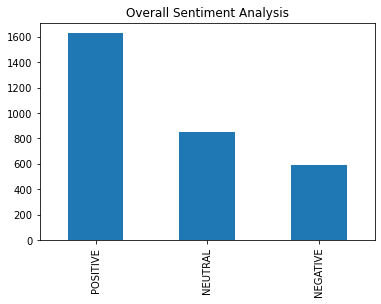

In [32]:
# Explore overall sentiments
df['sentiment_type'].value_counts().plot(kind='bar',title="Overall Sentiment Analysis");

In [33]:
# Explore percentage
df['sentiment_type'].value_counts(normalize = True)*100

POSITIVE    52.975610
NEUTRAL     27.739837
NEGATIVE    19.284553
Name: sentiment_type, dtype: float64

- Generally overall sentiments for both islands are positive with 52% at positive where else 19.2% are negative.
- Kindda of suprise as given the current situation of the pandemic. Both islands have restriction of tourist entry. being curious. i did a little research and discovered that phuket is actually opened to entry for low and medium risk destinations without quarantine restrictions. this may be the reason for the higher positive sentiments. where else bali is still rolling out for reopening in Oct 21.
ref: https://edition.cnn.com/travel/article/thailand-travel-covid-19/index.html 

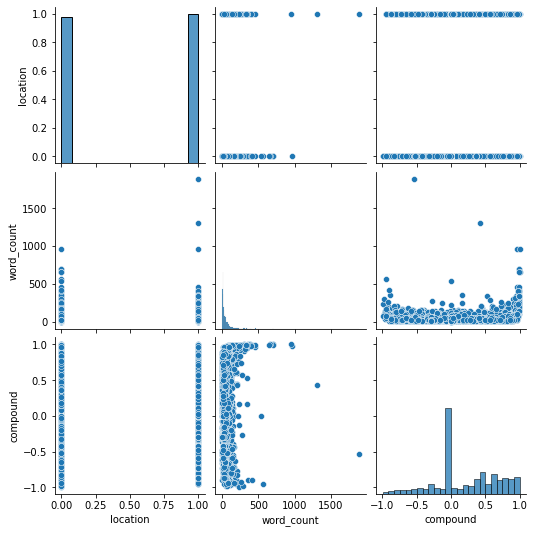

In [34]:
# Pairplot
sns.pairplot(df)

- From the pairplot observed, word counts are generally less than 500 per row with some outliers in the higher range.
- Locatiom is well balanced
- our compound(sentiments) has a high count in the slightly less than 0.0 range.

### EDA: Word Cloud

There are 379160 words in the combination of all features.


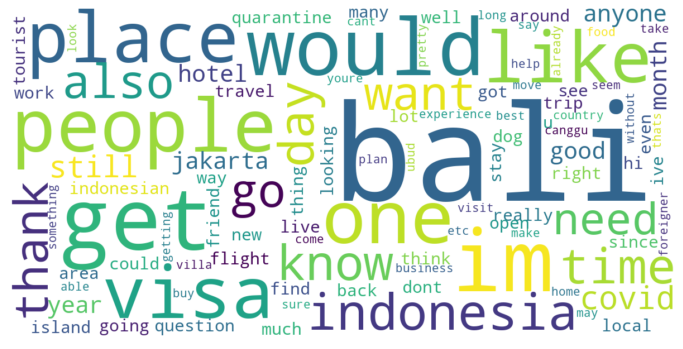

In [35]:
# EDA Cloud words for bali_df

text = " ".join(i for i in df[df['location']==0]['features'])
print ("There are {} words in the combination of all features.".format(len(text)))

# Generate word cloud image
wordcloud = WordCloud( stopwords = stop, background_color="white", 
                      max_words = 100, max_font_size = 80, scale = 3).generate(text)

fig = plt.figure(1, figsize=(12, 12))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


- The following are obvious words that pops out in the word cloud.Quarantine, villa, jakarta, Visa
- 'Quarantine'& 'Jakarta'. This may be due to essential visitors are to serve quarantine in Jakarta before visiting bali.
- 'Villa'. Those who have visited bali before. villas are spruced all over the island. thus the frequent mentioned of it.
- 'Visa'. it is assesed that visitors to bali will require visas. thus the frequent mentioned of it.

There are 348428 words in the combination of all features.


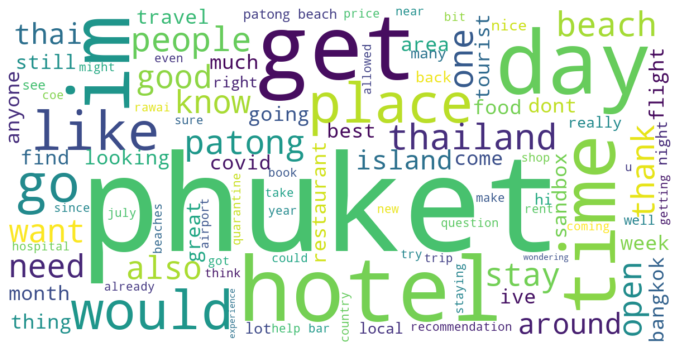

In [36]:
# EDA Cloud words for phuket_df

text = " ".join(i for i in df[df['location']==1]['features'])
print ("There are {} words in the combination of all features.".format(len(text)))

# Generate word cloud image
wordcloud = WordCloud( stopwords = stop, background_color="white", 
                      max_words = 100, max_font_size = 80, scale = 3).generate(text)

fig = plt.figure(1, figsize=(12, 12))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

- The following are obvious words that pops out in the phuket word cloud. 'Patong', 'hotel', 'bangkok', 'sandbox', 'open'.
- What we can analysis is Patong is a name of a place/beach in phuket, thus the frequent mentioned of it. 
- 'hotel, this may be due to tourists looking for recommendations for hotel in phuket. 
- 'bangkok' the capital of thailand. need to say more?
- 'sandbox' this is a term coined by the thai government. it refers to vaccinated tourists visiting thailand needing to serve a SHA hotel for 14 days in phuket before being allowed to travel to other destination in thailand. read more here:
https://www.thaiembassy.com/travel-to-thailand/no-quarantine-phuket-sandbox-plan
- 'open'. this may be due to easing of travel restrictions for vaccinated personnel and opening of the borders to thailand.

### EDA: Words frequncies

In [37]:
X = df['features']
y = df['location']

In [38]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

In [39]:
# Instantiate a CountVectorizer with the default hyperparameters with stop words.
cvec = CountVectorizer(stop_words = stop)

In [40]:
# fit and transform X_train with cvec
X_train_cv = cvec.fit_transform(X_train)

# create new dataframe of word counts
cv_train = pd.DataFrame(X_train_cv.todense(), columns=cvec.get_feature_names())

# set limit of most frequent words appeared to be 20
n_words = 30 

words = list(cv_train.sum().sort_values(ascending=False)[:n_words].index)
cv_train['location'] = y_train.values
cv_train_small = cv_train.groupby('location').sum()[words]
cv_train_small.head()

,bali,phuket,im,get,would,like,beach,people,know,one,...,visa,covid,days,open,thailand,need,still,stay,travel,looking
location,,,,,,,,,,,,,,,,,,,,,
0,677,0,222,170,175,149,29,130,126,110,...,125,83,61,60,17,69,72,60,71,66
1,3,666,152,169,149,158,226,105,94,90,...,33,72,94,92,134,77,72,84,73,75


In [41]:
#set sns / color condition
plt.style.use('seaborn')
sns.set(style="white", color_codes=True)
colors_palette = sns.color_palette("GnBu_d")
sns.set_palette(colors_palette)
colors = ['#37535e', '#3b748a', '#4095b5', '#52aec9', '#72bfc4', '#93d0bf']

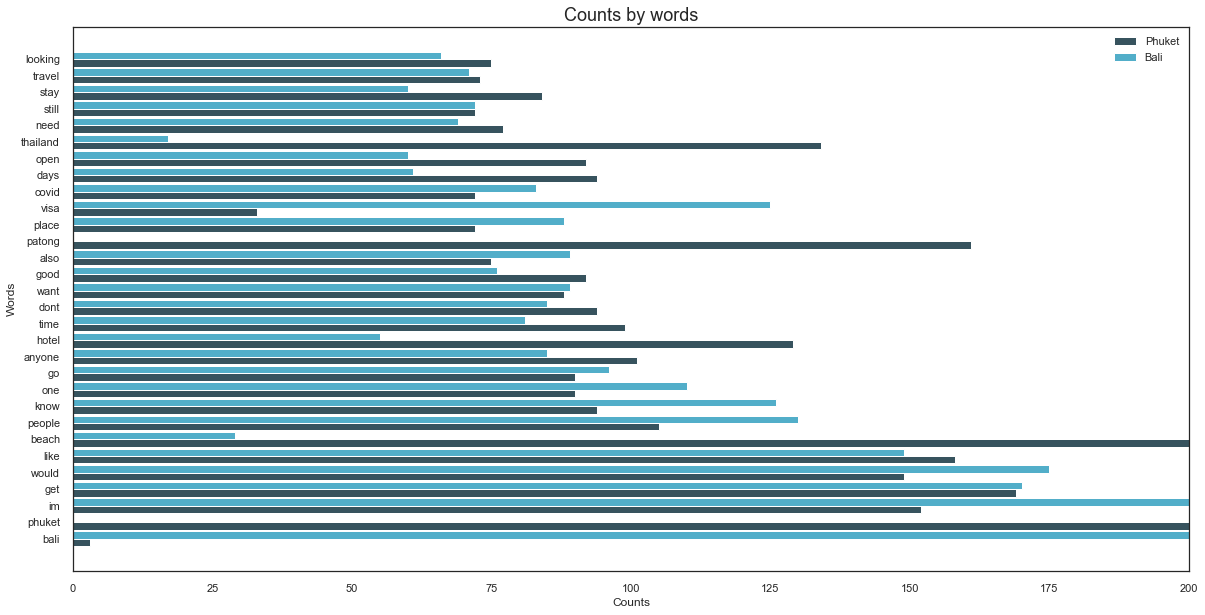

In [42]:
# Adapted from https://matplotlib.org/examples/api/barchart_demo.html

words_pkt = words
words_count_phuket = cv_train_small.loc[1]
words_bali = words
words_count_bali = cv_train_small.loc[0]
width = 0.45# the width of the bars
ind = np.arange(n_words)

fig, ax = plt.subplots(figsize=(20, 10))
bar1 = ax.barh(ind, words_count_phuket, width, color=colors[0])
bar2 = ax.barh(ind+width,words_count_bali, width, color=colors[3])

# add text for labels, title and axes ticks
ax.set_xlabel('Counts')
ax.set_ylabel('Words')
ax.set_title('Counts by words', fontsize = '18')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(words, rotation='horizontal')

#set limit for x value
ax.set_xlim(0,200)
#legend
ax.legend((bar1[0], bar2[0]), ('Phuket', 'Bali'))

plt.show()

- It is observed that there is no significant words that can differentiate the islands less names of places in the respective islands such as phuket, bali, patong.
- We will also want to take note that there is low mentions of beach in bali. i find it hard to believe as bali is a worthy destination for their beaches.

## Modelling

In [75]:
# create functions to return just the columns that we will need for feature engineering for our modelling
get_text_data = FunctionTransformer(lambda x: x['features'], validate = False)
get_numeric_data = FunctionTransformer(lambda x: x[['word_count', 'compound']], validate = False)

In [76]:
# set X, y features
X = df[['features', 'word_count','compound','sentiment_type']]
y = df['location']

# Instantiate X and y train test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, stratify = y, 
                                                    test_size=0.33,
                                                    random_state=42)

In [77]:
# Our Baseline score
y.value_counts(normalize = True)

1    0.505691
0    0.494309
Name: location, dtype: float64

### Modelling 1: RandomForestClassifier

In [78]:
# utilising pipline  to combine features and estimator 
pipe_rf = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer())
            ]))
    ])),
    ('rf', RandomForestClassifier())
])

params = { 'rf__n_estimators': [80,90,110,120],
          'rf__max_depth':[5,10,15,20],
            'features__text_features__cvec__stop_words' : [None, stop]}


gs_rf = GridSearchCV(pipe_rf, params, cv=5, verbose = 1, n_jobs = -1)

gs_rf.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('numeric_features',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x0000024F1D73DDC0>)),
                                                                                        ('ss',
                                                                                         StandardScaler())])),
                                                                       ('text_features',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x0000024F1D73DCA0>)),
                      

In [79]:
gs_rf.best_estimator_

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000024F1D73DDC0>)),
                                                                 ('ss',
                                                                  StandardScaler())])),
                                                ('text_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000024F1D73DCA0>)),
                                                                 ('cvec',
                                                                  CountVectorizer())]))])),
                ('rf', RandomForestClassifier(max_depth=20, n_estimators=110))])

In [81]:
print(f'Train Score: {gs_rf.score(X_train, y_train)}')
print(f'Test Score: {gs_rf.score(X_test, y_test)}')

Train Score: 0.9271844660194175
Test Score: 0.8285714285714286


Specificity: 0.900398406374502


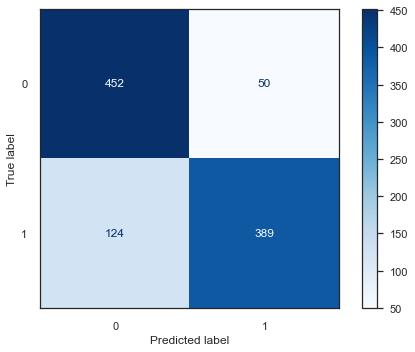

In [82]:
# Get predictions
preds = gs_rf.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# plot confusion matrix
plot_confusion_matrix(gs_rf, X_test, y_test, cmap='Blues', values_format='d')

# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec);

In [83]:
#f1 score
f1_score(y_test, preds)

0.8172268907563025

- RandomForestClassifer on our training set is overfitted.


### Modelling 2: Logistic Regression

In [84]:
pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer())
            ]))
    ])),
    ('logreg', LogisticRegression())
])

params = {
            'features__text_features__cvec__stop_words' : [None, stop],
            'logreg__penalty' : ['l1', 'l2'],
            'logreg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'logreg__C' : [100, 10, 1.0, 0.1, 0.01]
            
}

gs = GridSearchCV(pipe, params, cv=5, verbose = 1, n_jobs = -1)

gs.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('features',
                                        FeatureUnion(transformer_list=[('numeric_features',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x0000024F1D73DDC0>)),
                                                                                        ('ss',
                                                                                         StandardScaler())])),
                                                                       ('text_features',
                                                                        Pipeline(steps=[('selector',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x0000024F1D73DCA0>)),
                      

In [85]:
gs.best_estimator_

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000024F1D73DDC0>)),
                                                                 ('ss',
                                                                  StandardScaler())])),
                                                ('text_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x0000024F1D73DCA0>)),
                                                                 ('cvec',
                                                                  CountVectorizer(stop_words=['i',
                                                                           

In [86]:
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.9461165048543689
0.8423645320197044


Specificity: 0.8864541832669323


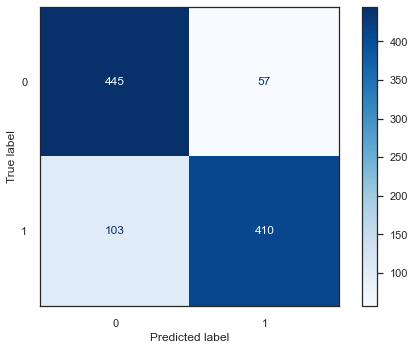

In [87]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# plot confusion matrix
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d')


# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec);

In [88]:
#f1 score
f1_score(y_test, preds)

0.836734693877551

- Logistic Regression train set is also slightly overfitted, its F1 score performed slightly better than Randomforestclassifier


## Evaluation

### Evaluation: ROC Curve

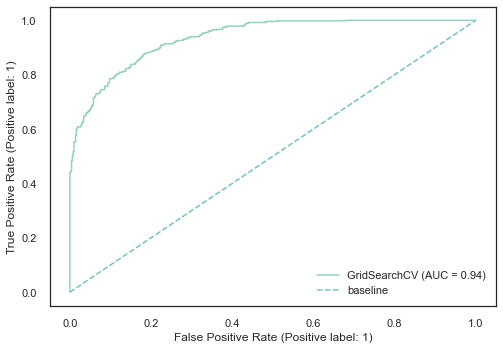

In [64]:
#Plot the True Positive Rate vs. False Positive Rate for the range of possible decision thresholds for Logistic Regression
plot_roc_curve(gs, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

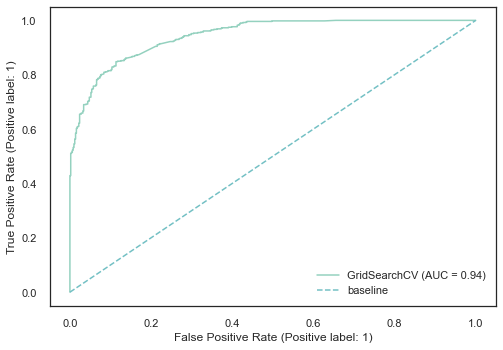

In [65]:
#Plot the True Positive Rate vs. False Positive Rate for the range of possible decision thresholds for RandomForrestClassifer
plot_roc_curve(gs_rf, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

In [66]:
# AUC Score for Logistic Regression, the closer your ROC AUC is to 1, the better. (1 is the maximum score.)
print(f'Logistic Regression: {roc_auc_score(y_test, gs.predict_proba(X_test)[:,1])}')
                              
print(f'RandomForestClassifier: {roc_auc_score(y_test, gs_rf.predict_proba(X_test)[:,1])}')

Logistic Regression: 0.935798715469506
RandomForestClassifier: 0.9443590161770073


- Both ROC scores differs slighlty with the Logistic Regression F1 scorescoring slightly better.

In [89]:
#re-creating our features variable:

features = ['word_count', 'compound'] +\
gs.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['cvec'].get_feature_names()

coefficients = gs.best_estimator_.named_steps['logreg'].coef_[0]

In [90]:
coef_df = pd.DataFrame({'features': features, 
              'coef' : coefficients,
              'exp_coef': [np.exp(coef) for coef in coefficients] #exponentiated coefficients
             })

coef_df.head(10)

,features,coef,exp_coef
0,word_count,0.195004,1.215316
1,compound,0.041119,1.041977
2,aabe,0.010525,1.010581
3,aadvantage,-0.023520,0.976755
4,aan,-0.019147,0.981035
5,ab,-0.005833,0.994184
6,abandoned,-0.067137,0.935068
7,abbreviated,0.000001,1.000001
8,abide,0.000201,1.000201
9,ability,-0.004912,0.995100


In [91]:
coef_df.loc[coef_df['features'] == 'sentiment']

,features,coef,exp_coef
7182,sentiment,-0.000763,0.999237


In [92]:
coef_df = coef_df.set_index('features')
coef_df = coef_df.sort_values('exp_coef', ascending = False)

In [93]:
coef_df['exp_coef'].head().sort_values()

features
thai         2.284577
beach        2.372965
patong       3.138521
thailand     3.252620
phuket      17.736642
Name: exp_coef, dtype: float64

In [95]:
coef_df['exp_coef'].tail().sort_values()

features
bali          0.053968
indonesia     0.401160
canggu        0.496763
business      0.523938
indonesian    0.530986
Name: exp_coef, dtype: float64

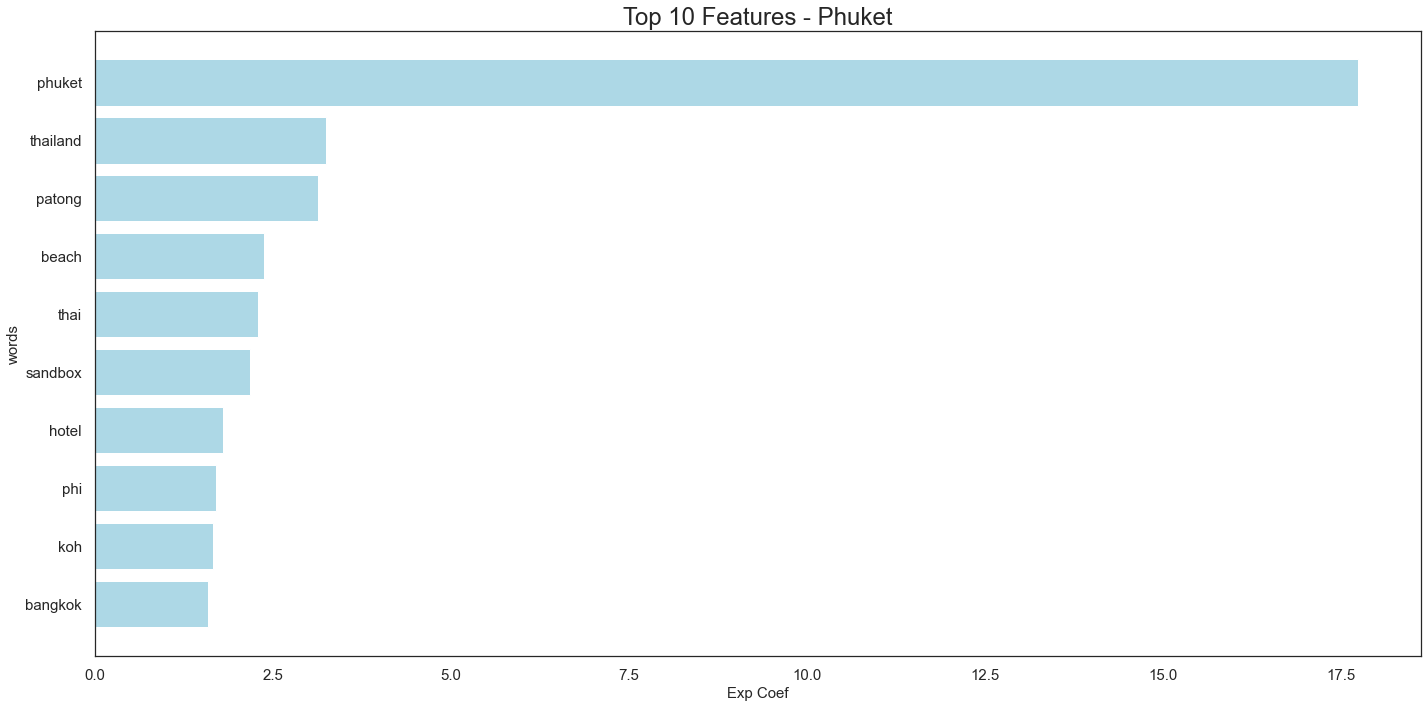

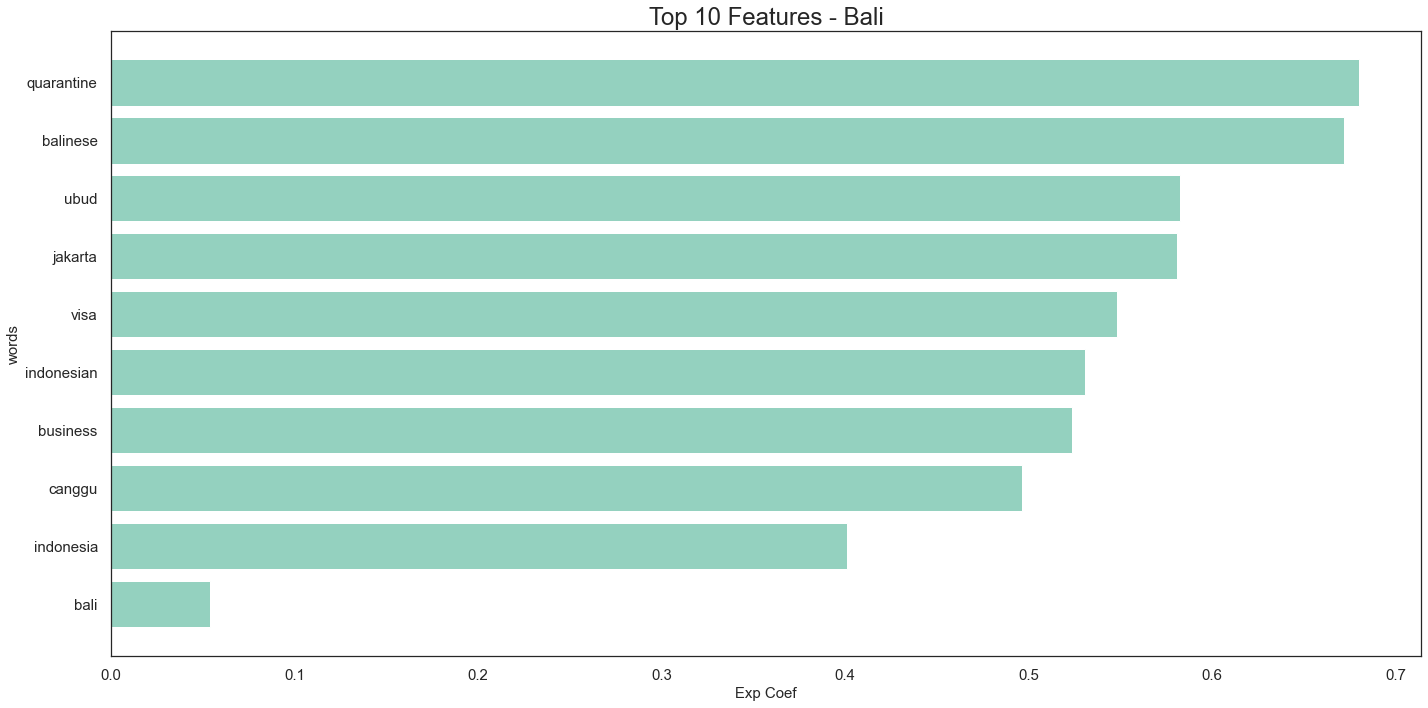

In [96]:
# plot top 10 features of phuket
weights = coef_df['exp_coef'].head(10).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = 'lightblue')
plt.yticks(fontsize=15)
plt.xticks( fontsize=15)
plt.xlabel('Exp Coef', fontsize=15)
plt.ylabel('words', fontsize=15)
plt.title(f'Top 10 Features - Phuket', fontsize=24)
plt.tight_layout()

# plot top 10 features of Bali
weights = coef_df['exp_coef'].tail(10).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights)
plt.yticks(fontsize=15)
plt.xticks( fontsize=15)
plt.xlabel('Exp Coef', fontsize=15)
plt.ylabel('words', fontsize=15)
plt.title(f'Top 10 Features - Bali', fontsize=24)
plt.tight_layout()



## Conclusion

From our modelling, we can deduce that logistic regression is the better model to predict the classification of the posts it is from. Either the island, Bali or Phuket. 

it is also observed that words such as names of places of the island or related locations provides a strong classifier between the 2 different places. however there are some words that are a point of interest such as 'business' in the bali features. this may imply business affected by covid or maybe people are heading to bali for business. for phuket would be 'sandbox' a termed coined by the thai govt to 'sandbox' vaccinated visitors to thailand in phuket before they are able to travel around the country. Sentiments are on the positive side for both islands. we hope this stays this way and await for travel to reopen fully.

## Recommendations

It is evident from the scoring of the accuracy and F1 scores that the logistic regression is the better consistent model classifier with slight differences from the Random Forrest Classifier model for this project. it's scoring is slightly lower than the Logistic Regression model but it is also the least overfitted / underfitted.
Thus, we will reccomend logistic regression model for the classification of posts from bali or phuket.

Noteably, from the train, test score it is observed that both models indicated a overfitness. If we are given more time, in the follow up to this project. we will would do more detailed hyper tuning of the model's parameters, reduced feature enginnering to curb overfitting and trying other models to achieve a better result with a better fit model.